In [1]:
import sys
import os

# Path to the project root (one level above the notebooks folder)
project_root = os.path.abspath("..")

# Add to Python path if not already present
if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root added:", project_root)

Project root added: /home/zervaki/Thesis_New


In [2]:
import os
os.getcwd()


'/home/zervaki/Thesis_New/notebooks'

In [3]:

%load_ext autoreload
%autoreload 2

In [4]:

from data.processed_mimic.aggregate_mimic import (
    load_mimic_tables, 
    select_labs, 
    aggregate_labs, 
    merge_with_patients_admissions, 
    save_dataset
)

In [5]:
# MIMIC iv dataset
patients, admissions, labevents, labitems = load_mimic_tables()
selected_labs = ['Potassium', 'Sodium', 'Creatinine', 'Chloride', 'Urea Nitrogen', 'Hematocrit']
filtered = select_labs(labevents, labitems, selected_labs)
admission_labs = aggregate_labs(filtered)
full_data = merge_with_patients_admissions(admission_labs, patients, admissions)
save_dataset(full_data)


Loading raw MIMIC CSVs...


FileNotFoundError: [Errno 2] No such file or directory: 'data/raw_mimic/mimic-iv-clinical-database-demo-2.2/hosp/patients.csv.gz'

In [8]:
import os
import pandas as pd

# ---------------------------------------------------------
# 1. Define the correct raw path relative to the notebook
# ---------------------------------------------------------
raw_path = "../data/raw_mimic/mimic-iv-clinical-database-demo-2.2/hosp"

# ---------------------------------------------------------
# 2. Load raw MIMIC tables
# ---------------------------------------------------------
print("Loading raw MIMIC CSVs...")

patients = pd.read_csv(f"{raw_path}/patients.csv.gz")
admissions = pd.read_csv(f"{raw_path}/admissions.csv.gz")
labevents = pd.read_csv(f"{raw_path}/labevents.csv.gz")
labitems = pd.read_csv(f"{raw_path}/d_labitems.csv.gz")

print("Loaded:")
print("  patients:", patients.shape)
print("  admissions:", admissions.shape)
print("  labevents:", labevents.shape)
print("  labitems:", labitems.shape)

# ---------------------------------------------------------
# 3. Select labs
# ---------------------------------------------------------
selected_labs = [
    "Potassium", "Sodium", "Creatinine",
    "Chloride", "Urea Nitrogen", "Hematocrit"
]

itemids = labitems[labitems["label"].isin(selected_labs)]["itemid"].tolist()

filtered = (
    labevents[labevents["itemid"].isin(itemids)]
    .merge(labitems[["itemid", "label"]], on="itemid", how="left")
)

print("Filtered lab events:", filtered.shape)

# ---------------------------------------------------------
# 4. Aggregate per admission
# ---------------------------------------------------------
agg = (
    filtered.groupby(["subject_id", "hadm_id", "label"])["valuenum"]
    .mean()
    .reset_index()
)

pivot = (
    agg.pivot_table(
        index=["subject_id", "hadm_id"],
        columns="label",
        values="valuenum"
    )
    .reset_index()
)

print("Aggregated pivot:", pivot.shape)

# ---------------------------------------------------------
# 5. Merge with admissions + patients
# ---------------------------------------------------------
full_data = (
    pivot
    .merge(admissions, on=["subject_id", "hadm_id"], how="left")
    .merge(patients, on="subject_id", how="left")
)

print("Final merged dataset:", full_data.shape)

# ---------------------------------------------------------
# 6. Inspect missingness
# ---------------------------------------------------------
print("\nMissing values per column:")
print(full_data.isnull().sum())

# ---------------------------------------------------------
# 7. Save processed dataset
# ---------------------------------------------------------
output_path = "../data/processed_mimic/processed_admissions_selected_labs.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)

full_data.to_csv(output_path, index=False)
print(f"\nSaved processed dataset to: {output_path}")


Loading raw MIMIC CSVs...
Loaded:
  patients: (100, 6)
  admissions: (275, 16)
  labevents: (107727, 16)
  labitems: (1622, 4)
Filtered lab events: (17900, 17)
Aggregated pivot: (251, 8)
Final merged dataset: (251, 27)

Missing values per column:
subject_id                0
hadm_id                   0
Chloride                  1
Creatinine                1
Hematocrit                3
Potassium                 1
Sodium                    1
Urea Nitrogen             1
admittime                 0
dischtime                 0
deathtime               236
admission_type            0
admit_provider_id         0
admission_location        0
discharge_location       21
insurance                 0
language                  0
marital_status           12
race                      0
edregtime                87
edouttime                87
hospital_expire_flag      0
gender                    0
anchor_age                0
anchor_year               0
anchor_year_group         0
dod                     1

In [9]:
list(full_data.columns)


['subject_id',
 'hadm_id',
 'Chloride',
 'Creatinine',
 'Hematocrit',
 'Potassium',
 'Sodium',
 'Urea Nitrogen',
 'admittime',
 'dischtime',
 'deathtime',
 'admission_type',
 'admit_provider_id',
 'admission_location',
 'discharge_location',
 'insurance',
 'language',
 'marital_status',
 'race',
 'edregtime',
 'edouttime',
 'hospital_expire_flag',
 'gender',
 'anchor_age',
 'anchor_year',
 'anchor_year_group',
 'dod']

In [10]:
import pandas as pd

# ---------------------------------------------------------
# 1. Select the core continuous physiology variables
# ---------------------------------------------------------
phys_vars = [
    "Chloride",
    "Creatinine",
    "Hematocrit",
    "Potassium",
    "Sodium",
    "Urea Nitrogen"
]

df_phys = full_data[phys_vars].copy()

# ---------------------------------------------------------
# 2. Drop rows with structural missingness
#    (only 1–3 rows per variable, so this is fine)
# ---------------------------------------------------------
df_phys = df_phys.dropna().reset_index(drop=True)

print("Shape after dropping structural NaNs:", df_phys.shape)

# ---------------------------------------------------------
# 3. Standardize the continuous variables
# ---------------------------------------------------------
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_phys_scaled = pd.DataFrame(
    scaler.fit_transform(df_phys),
    columns=phys_vars
)

df_phys_scaled.head()


Shape after dropping structural NaNs: (247, 6)


,Chloride,Creatinine,Hematocrit,Potassium,Sodium,Urea Nitrogen
0,0.692642,-0.754144,1.065523,0.741277,-0.129685,0.028875
1,-1.898565,-0.754144,0.672999,2.298458,-2.824834,0.230984
2,-1.549749,-0.640795,0.401970,4.022480,-3.641545,0.348881
3,-0.237535,-0.663465,0.289820,1.779398,-1.681437,0.382566
4,0.333859,-0.618125,0.616924,-0.548958,0.360342,-0.779559


In [11]:
import numpy as np
import pandas as pd

# ---------------------------------------------------------
# 1. Load your standardized physiology dataset
# ---------------------------------------------------------
X_complete = df_phys_scaled.values   # shape (247, 6)
num_var = X_complete.shape[1]

print("Complete data shape:", X_complete.shape)

# ---------------------------------------------------------
# 2. Generate a random DAG for the 6 variables
# ---------------------------------------------------------
from data.synthetic_data_generation.dag_and_data import (
    random_dag, detect_colliders, detect_collider_parents
)

G, adj = random_dag(n_nodes=num_var, seed=42)
colliders = detect_colliders(adj)
collider_parents = detect_collider_parents(adj, colliders)

print("Adjacency matrix:\n", adj)
print("Colliders:", colliders)
print("Collider parents:", collider_parents)

# ---------------------------------------------------------
# 3. Create MAR missingness indicators
# ---------------------------------------------------------
from data.synthetic_data_generation.missingness_synthetic import (
    create_mar_ind, generate_missing_values, generate_mcar_reference
)

ms_mar, prt_ms_mar = create_mar_ind(
    colliders=colliders,
    collider_parents=collider_parents,
    num_var=num_var,
    num_extra_e=1,
    num_m=3,
    seed=42
)

print("MAR missingness indicators:", ms_mar)
print("MAR parents:", prt_ms_mar)

# ---------------------------------------------------------
# 4. Apply MAR missingness
# ---------------------------------------------------------
X_mar = generate_missing_values(
    X_complete=X_complete,
    ms=ms_mar,
    prt_ms=prt_ms_mar,
    p_missing_h=0.9,
    p_missing_l=0.1,
    seed=42
)

print("MAR missingness summary:")
print(pd.DataFrame(X_mar).isnull().mean())

# ---------------------------------------------------------
# 5. Generate MCAR reference (optional)
# ---------------------------------------------------------
X_mcar = generate_mcar_reference(
    X_complete=X_complete,
    X_mar=X_mar,
    ms=ms_mar,
    seed=42
)

# ---------------------------------------------------------
# 6. Create MNAR missingness indicators
# ---------------------------------------------------------
from data.synthetic_data_generation.missingness_synthetic import create_mnar_ind

ms_mnar, prt_ms_mnar = create_mnar_ind(
    colliders=colliders,
    collider_parents=collider_parents,
    num_var=num_var,
    num_extra_e=1,
    num_m=3,
    seed=42
)

print("MNAR missingness indicators:", ms_mnar)
print("MNAR parents:", prt_ms_mnar)

# ---------------------------------------------------------
# 7. Apply MNAR missingness
# ---------------------------------------------------------
X_mnar = generate_missing_values(
    X_complete=X_complete,
    ms=ms_mnar,
    prt_ms=prt_ms_mnar,
    p_missing_h=0.9,
    p_missing_l=0.1,
    seed=42
)

print("MNAR missingness summary:")
print(pd.DataFrame(X_mnar).isnull().mean())

# ---------------------------------------------------------
# 8. Save datasets
# ---------------------------------------------------------
df_mar = pd.DataFrame(X_mar, columns=df_phys_scaled.columns)
df_mnar = pd.DataFrame(X_mnar, columns=df_phys_scaled.columns)
df_mcar = pd.DataFrame(X_mcar, columns=df_phys_scaled.columns)

df_mar.to_csv("../data/processed_mimic/mimic_mar.csv", index=False)
df_mnar.to_csv("../data/processed_mimic/mimic_mnar.csv", index=False)
df_mcar.to_csv("../data/processed_mimic/mimic_mcar.csv", index=False)

print("Saved MAR, MNAR, MCAR datasets.")


Complete data shape: (247, 6)
Adjacency matrix:
 [[0 0 0 0 0 0]
 [1 0 0 1 0 0]
 [0 1 0 0 1 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 0 0 1 1 0]]
Colliders: [0, 3, 4]
Collider parents: [[np.int64(1), np.int64(5)], [np.int64(1), np.int64(5)], [np.int64(2), np.int64(5)]]
MAR missingness indicators: [np.int64(1), 2, 4]
MAR parents: [0, 3, 5]
MAR missingness summary:
0    0.000000
1    0.319838
2    0.392713
3    0.000000
4    0.692308
5    0.000000
dtype: float64
MNAR missingness indicators: [np.int64(1), 0, 2]
MNAR parents: [0, np.int64(5), np.int64(5)]
MNAR missingness summary:
0    0.396761
1    0.319838
2    0.692308
3    0.000000
4    0.000000
5    0.000000
dtype: float64
Saved MAR, MNAR, MCAR datasets.


In [12]:
import numpy as np
import pandas as pd

from mvpc.mvpc_pipeline import MVPC
from mvpc.ci_tests.gauss_permc import gauss_ci_td, gauss_ci_permc
from mvpc.ci_tests.gauss_drw import gauss_ci_drw

# ---------------------------------------------------------
# 1. Load MIMIC datasets
# ---------------------------------------------------------
df_mar = pd.read_csv("../data/processed_mimic/mimic_mar.csv")
df_mnar = pd.read_csv("../data/processed_mimic/mimic_mnar.csv")
df_mcar = pd.read_csv("../data/processed_mimic/mimic_mcar.csv")

X_mar = df_mar.values
X_mnar = df_mnar.values
X_mcar = df_mcar.values

print("Shapes:", X_mar.shape, X_mnar.shape, X_mcar.shape)

# ---------------------------------------------------------
# 2. Ground truth adjacency (from your earlier DAG)
# ---------------------------------------------------------
adj_true = adj   # reuse the adjacency matrix from your MAR/MNAR generation

# ---------------------------------------------------------
# 3. SHD + F1 helpers (same as synthetic)
# ---------------------------------------------------------
def shd_skeleton(G_est, G_true):
    G_est_sym = ((G_est + G_est.T) > 0).astype(int)
    G_true_sym = ((G_true + G_true.T) > 0).astype(int)
    return np.sum(G_est_sym != G_true_sym)

def f1_skeleton(G_est, G_true):
    G_est_sym = ((G_est + G_est.T) > 0).astype(int)
    G_true_sym = ((G_true + G_true.T) > 0).astype(int)
    triu_idx = np.triu_indices_from(G_true_sym, k=1)
    est = G_est_sym[triu_idx]
    true = G_true_sym[triu_idx]
    TP = np.sum((est == 1) & (true == 1))
    FP = np.sum((est == 1) & (true == 0))
    FN = np.sum((est == 0) & (true == 1))
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    return 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

# ---------------------------------------------------------
# 4. Run MVPC for all methods
# ---------------------------------------------------------
def run_mvpc_all_methods(X_m, adj_true):
    results = {}

    # TD-PC
    mvpc_td = MVPC(indep_test=gauss_ci_td, corr_test=gauss_ci_td, alpha=0.05)
    G_td = mvpc_td.run(X_m)["G_corrected"]
    results["TD"] = {
        "shd": shd_skeleton(G_td, adj_true),
        "f1": f1_skeleton(G_td, adj_true),
    }

    # PermC
    mvpc_permc = MVPC(indep_test=gauss_ci_td, corr_test=gauss_ci_permc, alpha=0.05)
    G_permc = mvpc_permc.run(X_m)["G_corrected"]
    results["PERMC"] = {
        "shd": shd_skeleton(G_permc, adj_true),
        "f1": f1_skeleton(G_permc, adj_true),
    }

    # DRW
    mvpc_drw = MVPC(indep_test=gauss_ci_td, corr_test=gauss_ci_drw, alpha=0.05)
    G_drw = mvpc_drw.run(X_m)["G_corrected"]
    results["DRW"] = {
        "shd": shd_skeleton(G_drw, adj_true),
        "f1": f1_skeleton(G_drw, adj_true),
    }

    return results

# ---------------------------------------------------------
# 5. Evaluate MAR, MNAR, MCAR
# ---------------------------------------------------------
results_mimic = {
    "MAR": run_mvpc_all_methods(X_mar, adj_true),
    "MNAR": run_mvpc_all_methods(X_mnar, adj_true),
    "MCAR": run_mvpc_all_methods(X_mcar, adj_true),
}

results_mimic


Shapes: (247, 6) (247, 6) (247, 6)
[Step 1] m_inds (vars with NaNs): [1, 2, 4]


Detecting parents of missingness indicators:   0%|          | 0/3 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(0)]


[Step 1] R_ind=2, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 3/3 [00:00<00:00, 330.55it/s]


[Step 1] R_ind=4, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 4]
[Step 1] prt dict: {1: [np.int64(0)], 2: [np.int64(3)], 4: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4]


Detecting parents of missingness indicators:   0%|          | 0/3 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(0)]


[Step 1] R_ind=2, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 3/3 [00:00<00:00, 368.73it/s]


[Step 1] R_ind=4, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 4]
[Step 1] prt dict: {1: [np.int64(0)], 2: [np.int64(3)], 4: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4]


Detecting parents of missingness indicators:   0%|          | 0/3 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(0)]


[Step 1] R_ind=2, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 3/3 [00:00<00:00, 370.99it/s]


[Step 1] R_ind=4, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 4]
[Step 1] prt dict: {1: [np.int64(0)], 2: [np.int64(3)], 4: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2]


Detecting parents of missingness indicators:   0%|          | 0/3 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(3), np.int64(5)]


[Step 1] R_ind=1, parents=[np.int64(0)]


Detecting parents of missingness indicators: 100%|██████████| 3/3 [00:00<00:00, 329.36it/s]


[Step 1] R_ind=2, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 2]
[Step 1] prt dict: {0: [np.int64(3), np.int64(5)], 1: [np.int64(0)], 2: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2]


Detecting parents of missingness indicators:   0%|          | 0/3 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(3), np.int64(5)]


[Step 1] R_ind=1, parents=[np.int64(0)]


Detecting parents of missingness indicators: 100%|██████████| 3/3 [00:00<00:00, 321.47it/s]


[Step 1] R_ind=2, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 2]
[Step 1] prt dict: {0: [np.int64(3), np.int64(5)], 1: [np.int64(0)], 2: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2]


Detecting parents of missingness indicators:   0%|          | 0/3 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(3), np.int64(5)]


[Step 1] R_ind=1, parents=[np.int64(0)]


Detecting parents of missingness indicators: 100%|██████████| 3/3 [00:00<00:00, 330.49it/s]


[Step 1] R_ind=2, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 2]
[Step 1] prt dict: {0: [np.int64(3), np.int64(5)], 1: [np.int64(0)], 2: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4]


Detecting parents of missingness indicators:   0%|          | 0/3 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 3/3 [00:00<00:00, 727.88it/s]


[Step 1] R_ind=4, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [1, 2, 4]


Detecting parents of missingness indicators:   0%|          | 0/3 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 3/3 [00:00<00:00, 743.63it/s]


[Step 1] R_ind=4, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [1, 2, 4]


Detecting parents of missingness indicators:   0%|          | 0/3 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 3/3 [00:00<00:00, 733.53it/s]


[Step 1] R_ind=4, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


{'MAR': {'TD': {'shd': np.int64(16), 'f1': np.float64(0.3333333333333333)},
  'PERMC': {'shd': np.int64(16), 'f1': np.float64(0.3333333333333333)},
  'DRW': {'shd': np.int64(16), 'f1': np.float64(0.3333333333333333)}},
 'MNAR': {'TD': {'shd': np.int64(16), 'f1': np.float64(0.2)},
  'PERMC': {'shd': np.int64(16), 'f1': np.float64(0.2)},
  'DRW': {'shd': np.int64(16), 'f1': np.float64(0.2)}},
 'MCAR': {'TD': {'shd': np.int64(12), 'f1': np.float64(0.5)},
  'PERMC': {'shd': np.int64(12), 'f1': np.float64(0.5)},
  'DRW': {'shd': np.int64(12), 'f1': np.float64(0.5)}}}

In [13]:
import pandas as pd

rows = []
for mode, methods in results_mimic.items():
    for method, metrics in methods.items():
        rows.append({
            "mode": mode,
            "method": method,
            "shd": float(metrics["shd"]),
            "f1": float(metrics["f1"]),
        })

df_mimic_results = pd.DataFrame(rows)
df_mimic_results


,mode,method,shd,f1
0,MAR,TD,16.0,0.333333
1,MAR,PERMC,16.0,0.333333
2,MAR,DRW,16.0,0.333333
3,MNAR,TD,16.0,0.200000
4,MNAR,PERMC,16.0,0.200000
5,MNAR,DRW,16.0,0.200000
6,MCAR,TD,12.0,0.500000
7,MCAR,PERMC,12.0,0.500000
8,MCAR,DRW,12.0,0.500000


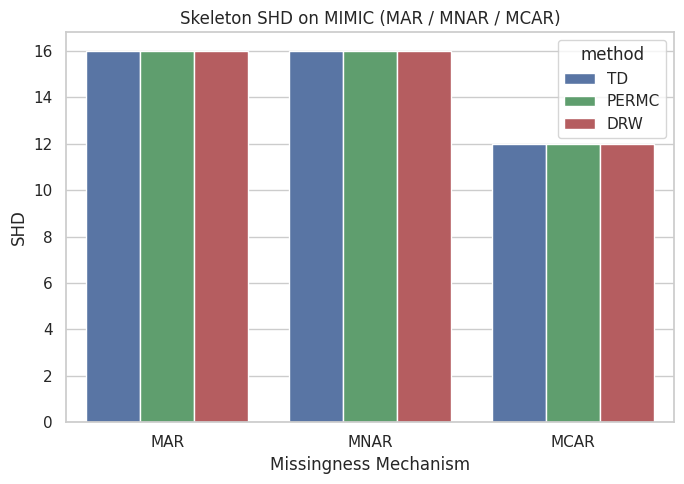

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

plt.figure(figsize=(7,5))
sns.barplot(
    data=df_mimic_results,
    x="mode",
    y="shd",
    hue="method",
    palette=["#4C72B0", "#55A868", "#C44E52"]
)

plt.title("Skeleton SHD on MIMIC (MAR / MNAR / MCAR)")
plt.xlabel("Missingness Mechanism")
plt.ylabel("SHD")
plt.tight_layout()
plt.show()


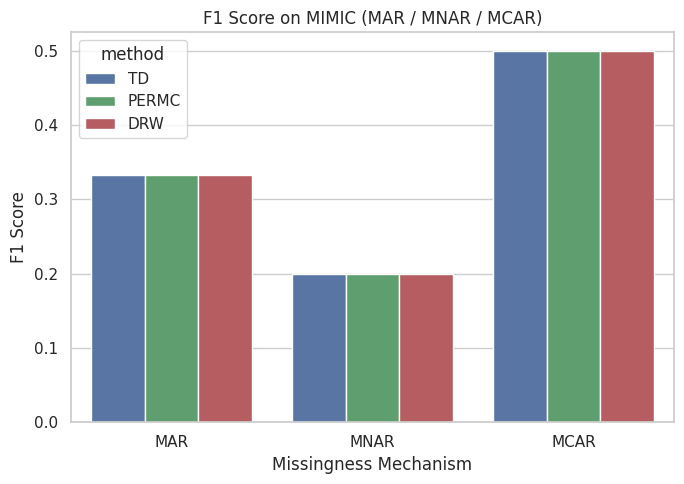

In [15]:
plt.figure(figsize=(7,5))
sns.barplot(
    data=df_mimic_results,
    x="mode",
    y="f1",
    hue="method",
    palette=["#4C72B0", "#55A868", "#C44E52"]
)

plt.title("F1 Score on MIMIC (MAR / MNAR / MCAR)")
plt.xlabel("Missingness Mechanism")
plt.ylabel("F1 Score")
plt.tight_layout()
plt.show()


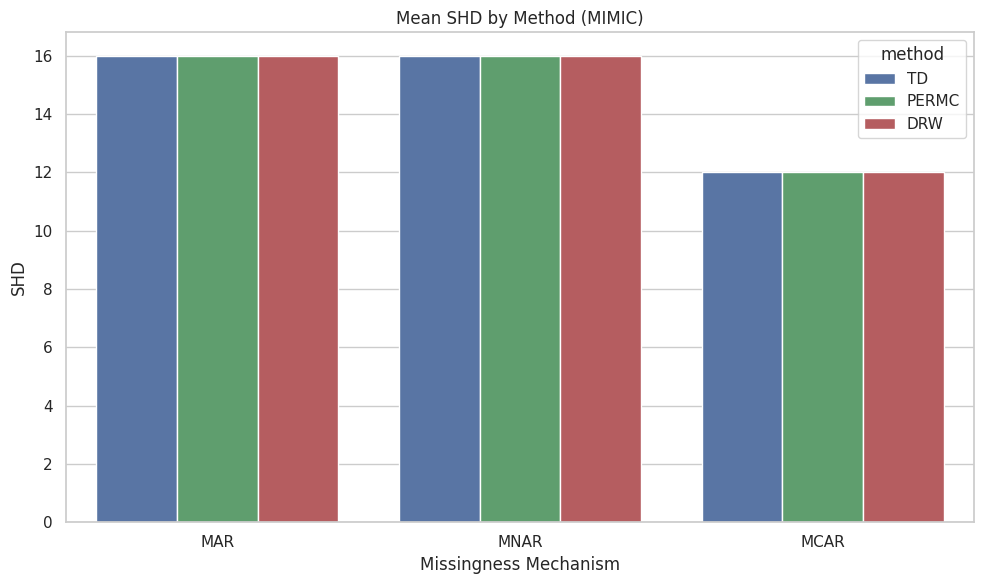

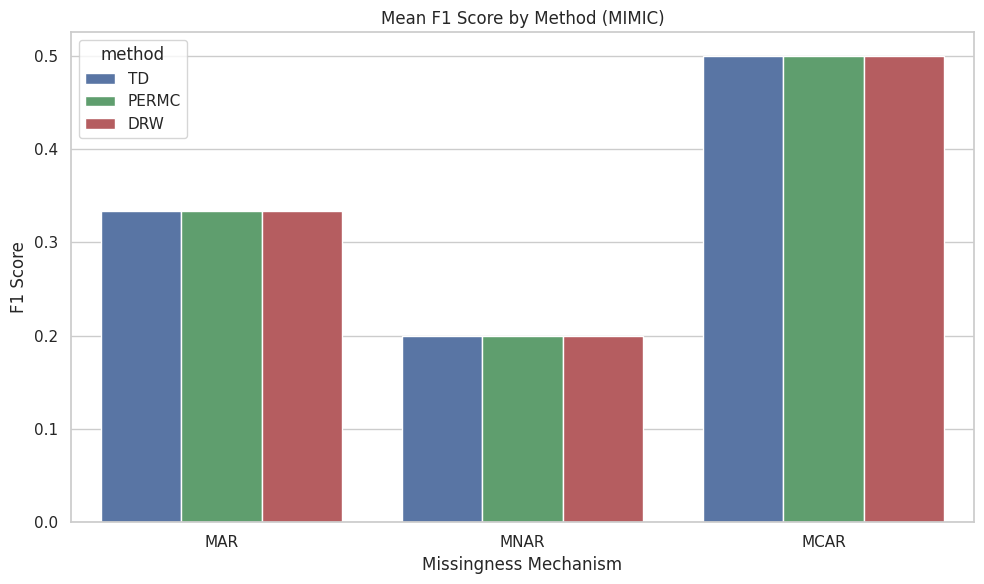

In [16]:
def plot_grouped_histogram(df, metric, ylabel, title):
    plt.figure(figsize=(10,6))
    sns.barplot(
        data=df,
        x="mode",
        y=metric,
        hue="method",
        palette=["#4C72B0", "#55A868", "#C44E52"],
        errorbar=None
    )
    plt.title(title)
    plt.xlabel("Missingness Mechanism")
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

plot_grouped_histogram(df_mimic_results, "shd", "SHD", "Mean SHD by Method (MIMIC)")
plot_grouped_histogram(df_mimic_results, "f1", "F1 Score", "Mean F1 Score by Method (MIMIC)")


In [17]:
for mode_name, X_m in [("MAR", X_mar), ("MNAR", X_mnar), ("MCAR", X_mcar)]:
    print(f"\n=== {mode_name} ===")
    mvpc_td = MVPC(indep_test=gauss_ci_td, corr_test=gauss_ci_td, alpha=0.05)
    mvpc_permc = MVPC(indep_test=gauss_ci_td, corr_test=gauss_ci_permc, alpha=0.05)
    mvpc_drw = MVPC(indep_test=gauss_ci_td, corr_test=gauss_ci_drw, alpha=0.05)

    G_td = mvpc_td.run(X_m)["G_corrected"]
    G_permc = mvpc_permc.run(X_m)["G_corrected"]
    G_drw = mvpc_drw.run(X_m)["G_corrected"]

    print("TD vs PERMC equal:", np.array_equal(G_td, G_permc))
    print("TD vs DRW equal:", np.array_equal(G_td, G_drw))



=== MAR ===
[Step 1] m_inds (vars with NaNs): [1, 2, 4]


Detecting parents of missingness indicators:   0%|          | 0/3 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(0)]


[Step 1] R_ind=2, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 3/3 [00:00<00:00, 435.43it/s]


[Step 1] R_ind=4, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 4]
[Step 1] prt dict: {1: [np.int64(0)], 2: [np.int64(3)], 4: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4]


Detecting parents of missingness indicators:   0%|          | 0/3 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(0)]


[Step 1] R_ind=2, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 3/3 [00:00<00:00, 475.04it/s]


[Step 1] R_ind=4, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 4]
[Step 1] prt dict: {1: [np.int64(0)], 2: [np.int64(3)], 4: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4]


Detecting parents of missingness indicators:   0%|          | 0/3 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(0)]


[Step 1] R_ind=2, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 3/3 [00:00<00:00, 468.79it/s]


[Step 1] R_ind=4, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 4]
[Step 1] prt dict: {1: [np.int64(0)], 2: [np.int64(3)], 4: [np.int64(5)]}


TD vs PERMC equal: True
TD vs DRW equal: True

=== MNAR ===
[Step 1] m_inds (vars with NaNs): [0, 1, 2]


Detecting parents of missingness indicators:   0%|          | 0/3 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(3), np.int64(5)]


[Step 1] R_ind=1, parents=[np.int64(0)]


Detecting parents of missingness indicators: 100%|██████████| 3/3 [00:00<00:00, 417.68it/s]


[Step 1] R_ind=2, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 2]
[Step 1] prt dict: {0: [np.int64(3), np.int64(5)], 1: [np.int64(0)], 2: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2]


Detecting parents of missingness indicators:   0%|          | 0/3 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(3), np.int64(5)]


[Step 1] R_ind=1, parents=[np.int64(0)]


Detecting parents of missingness indicators: 100%|██████████| 3/3 [00:00<00:00, 421.00it/s]


[Step 1] R_ind=2, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 2]
[Step 1] prt dict: {0: [np.int64(3), np.int64(5)], 1: [np.int64(0)], 2: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [0, 1, 2]


Detecting parents of missingness indicators:   0%|          | 0/3 [00:00<?, ?it/s]

[Step 1] R_ind=0, parents=[np.int64(3), np.int64(5)]


[Step 1] R_ind=1, parents=[np.int64(0)]


Detecting parents of missingness indicators: 100%|██████████| 3/3 [00:00<00:00, 425.88it/s]


[Step 1] R_ind=2, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [0, 1, 2]
[Step 1] prt dict: {0: [np.int64(3), np.int64(5)], 1: [np.int64(0)], 2: [np.int64(5)]}


TD vs PERMC equal: True
TD vs DRW equal: True

=== MCAR ===
[Step 1] m_inds (vars with NaNs): [1, 2, 4]


Detecting parents of missingness indicators:   0%|          | 0/3 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 3/3 [00:00<00:00, 932.76it/s]


[Step 1] R_ind=4, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [1, 2, 4]


Detecting parents of missingness indicators:   0%|          | 0/3 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 3/3 [00:00<00:00, 938.11it/s]


[Step 1] R_ind=4, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


[Step 1] m_inds (vars with NaNs): [1, 2, 4]


Detecting parents of missingness indicators:   0%|          | 0/3 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[]


[Step 1] R_ind=2, parents=[]


Detecting parents of missingness indicators: 100%|██████████| 3/3 [00:00<00:00, 936.51it/s]


[Step 1] R_ind=4, parents=[]
[Step 1] m_inds_filtered (with ≥1 parent): []
[Step 1] prt dict: {}


TD vs PERMC equal: True
TD vs DRW equal: True


In [18]:
G_td   = mvpc_td.run(X_mar)["G_corrected"]
G_perc = mvpc_permc.run(X_mar)["G_corrected"]
G_drw  = mvpc_drw.run(X_mar)["G_corrected"]

print("TD vs PermC equal? ",  np.array_equal(G_td, G_perc))
print("TD vs DRW equal?   ",  np.array_equal(G_td, G_drw))
print("PermC vs DRW equal?",  np.array_equal(G_perc, G_drw))


[Step 1] m_inds (vars with NaNs): [1, 2, 4]


Detecting parents of missingness indicators:   0%|          | 0/3 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(0)]


[Step 1] R_ind=2, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 3/3 [00:00<00:00, 449.71it/s]


[Step 1] R_ind=4, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 4]
[Step 1] prt dict: {1: [np.int64(0)], 2: [np.int64(3)], 4: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4]


Detecting parents of missingness indicators:   0%|          | 0/3 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(0)]


[Step 1] R_ind=2, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 3/3 [00:00<00:00, 437.70it/s]


[Step 1] R_ind=4, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 4]
[Step 1] prt dict: {1: [np.int64(0)], 2: [np.int64(3)], 4: [np.int64(5)]}


[Step 1] m_inds (vars with NaNs): [1, 2, 4]


Detecting parents of missingness indicators:   0%|          | 0/3 [00:00<?, ?it/s]

[Step 1] R_ind=1, parents=[np.int64(0)]


[Step 1] R_ind=2, parents=[np.int64(3)]


Detecting parents of missingness indicators: 100%|██████████| 3/3 [00:00<00:00, 472.97it/s]


[Step 1] R_ind=4, parents=[np.int64(5)]
[Step 1] m_inds_filtered (with ≥1 parent): [1, 2, 4]
[Step 1] prt dict: {1: [np.int64(0)], 2: [np.int64(3)], 4: [np.int64(5)]}


TD vs PermC equal?  True
TD vs DRW equal?    True
PermC vs DRW equal? True
